# Implementing k-means

First we create the dataset. It will have 1500 samples and we want to use k-means to detect clusters in this dataset.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

np.random.seed(0)

n_samples = 1500
X, y = datasets.make_blobs(n_samples=n_samples, random_state=8)

In [3]:
print(X)
print(y)

[[  5.86749807   8.17715188]
 [  5.61369982   9.93295527]
 [  7.22508428  10.44886194]
 ..., 
 [  7.73674097  10.82855388]
 [ -4.61701094  -9.64855983]
 [ -3.48640175  -9.25766922]]
[0 0 0 ..., 0 2 2]


Let's visualise the dataset. The clusters are clearly visible to us.

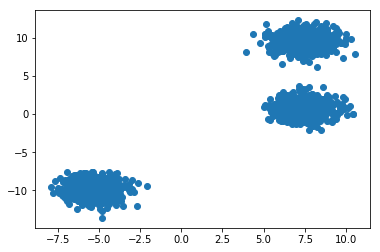

In [4]:
plt.scatter(X[:, 0], X[:, 1])
plt.show()
plt.gcf().clear()

To start the k-means calculation we pick three centroids - randomly, so in this case we select the first three points in the dataset.

In [4]:
k = 3
centroids = np.array(X[:k])
print(centroids)

[[  5.86749807   8.17715188]
 [  5.61369982   9.93295527]
 [  7.22508428  10.44886194]]


Have a look at the dataset again and show the locations of the centroids.

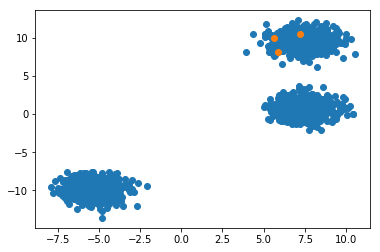

In [5]:
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1])
plt.show()
plt.gcf().clear()

Now we start using Spark. The first operation is the creation of a "Resilient Distributed Dataset" (RDD) which means distributing the data to the available nodes. This could be any size of underlying cluster - the user doesn't see the details.

Note that this is just a demo and normally the dataset would be available on the compute nodes.

In [6]:
rdd = sc.parallelize(X)
rdd.cache()

ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:475

We tell Spark to cache this dataset because k-means is an iterative algorithm and we will scan through the data many times. (In this case, the dataset is so small that it will be easily kept in memory. However, if necessary, Spark can spill to disk if the dataset grows too large.)

Let's see how many records are in the dataset: Call the function count.

In [7]:
rdd.count()

1500

For the k-means algorithm we need to define a cost function. We will use the squared Euclidean distance which is the "distance" between points.

In [8]:
from math import sqrt
def cost_function(x, y):
    return sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)

We can test the cost function on two random points of the dataset:

In [9]:
cost_function(X[205], X[978])

0.9590304461225516

Now we start the first k-means iteration: For each point in the dataset we calculate the distances to each of the centroids. Then we assign the point to the centroid to which it has the smallest distance.

Spark allows us to do this quite easily: "For each" means we apply the "map" function, and define the output as a lambda. So the following means that each point x is mapped to a tuple with itself (x) as the first element, and the second element is a list of distances to all the centroids.

In [10]:
d = rdd.map(lambda x: (x, [cost_function(x, centroids[i]) for i in range(k)]))

At this point, Spark has not actually "materialised" the dataset so no computations have actually happened because we only applied a "transformation". To kick off the calculation we need to use an "action", for example "take" which returns the first n elements of a dataset. Let's have a look at the first 2 entries that from our mapping.

In [11]:
d.take(2)

[(array([ 5.86749807,  8.17715188]),
  [0.0, 1.7740516007978733, 2.646451758613209]),
 (array([ 5.61369982,  9.93295527]),
  [1.7740516007978733, 0.0, 1.6919573226760787])]

Now that we know all the distances we can pick the centroid that have the smallest distance to our point. To do this we map each point to a tuple of itself and the centroid.

In [12]:
assignments = d.map(lambda (x, c): (c.index(min(c)), x))
assignments.take(10)

[(0, array([ 5.86749807,  8.17715188])),
 (1, array([ 5.61369982,  9.93295527])),
 (2, array([  7.22508428,  10.44886194])),
 (0, array([ 6.76282255,  0.60514535])),
 (0, array([ 8.0161824 ,  1.54314701])),
 (0, array([ 8.40185356, -0.37348132])),
 (1, array([ 6.51192277,  9.81342902])),
 (0, array([ 7.3996796 ,  0.91258881])),
 (0, array([ -4.98436335, -11.42227525])),
 (0, array([ 9.88825096,  0.90241392]))]

Now we can plot the assignments of points to their centroids.

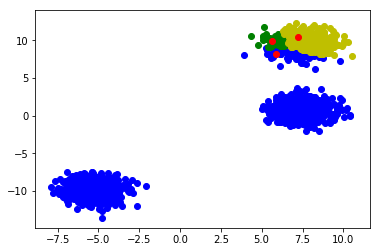

In [13]:
colours = ['b','g','y']
for i in range(k):
    all_assigned = np.array(assignments.filter(lambda (a, x): a==i).map(lambda (c, x): x).collect())
    plt.scatter(all_assigned[:,0], all_assigned[:,1], color=colours[i])
    plt.scatter([centroids[i][0]], [centroids[i][1]], color=['r'])
plt.show()
plt.gcf().clear()

That doesn't look very good. Both of the lower clusters are assigned to the same centroid and the one at the top is split across all three centroids. Let's see how many points are assigned to each cluster: This is a class "Map-Reduce" operation for counting groups.

In [14]:
assignments.map(lambda (c, a): (c, 1)).reduceByKey(lambda a,b: a+b).collect()

[(0, 1124), (1, 57), (2, 319)]

Actually, Spark has a built-in function that does this directly:

In [15]:
assignments.countByKey()

defaultdict(int, {0: 1124, 1: 57, 2: 319})

Now we start the next iteration: For each cluster we calculate a new centroid as the mean of all points in this cluster. So we first need to separate the clusters.

In [16]:
c0 = assignments.filter(lambda (a, x): a==0).map(lambda (a, x): x)
c1 = assignments.filter(lambda (a, x): a==1).map(lambda (a, x): x)
c2 = assignments.filter(lambda (a, x): a==2).map(lambda (a, x): x)
c0.take(10)

[array([ 5.86749807,  8.17715188]),
 array([ 6.76282255,  0.60514535]),
 array([ 8.0161824 ,  1.54314701]),
 array([ 8.40185356, -0.37348132]),
 array([ 7.3996796 ,  0.91258881]),
 array([ -4.98436335, -11.42227525]),
 array([ 9.88825096,  0.90241392]),
 array([ 7.95311372,  8.36897664]),
 array([ 6.10846066,  8.23343995]),
 array([-6.66843698, -9.35707168])]

We now calculate the mean for each cluster and that yields the new centroids.

In [17]:
print(c0.sum())
print(c0.count())
new_centroids = [c0.sum()/c0.count(), c1.sum()/c1.count(), c2.sum()/c2.count()]
print(new_centroids)

[ 1912.08080524 -3537.79137713]
1124
[array([ 1.70113951, -3.14750123]), array([ 5.88201222,  9.8330787 ]), array([ 7.96381989,  9.8000387 ])]


Now we use the same method as before to assign the points to their new centroids.

In [1]:
d = rdd.map(lambda x: (x, [cost_function(x, new_centroids[i]) for i in range(k)]))
new_assignments = d.map(lambda (x, c): (c.index(min(c)), x))
new_assignments.take(10)

NameError: name 'rdd' is not defined

And plot the results.

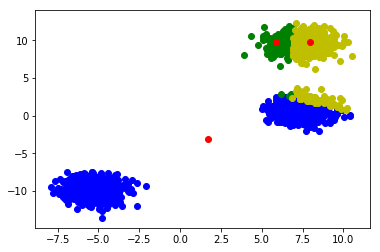

In [19]:
colours = ['b','g','y']
for i in range(k):
    all_assigned = np.array(new_assignments.filter(lambda (a, x): a==i).map(lambda (c, x): x).collect())
    plt.scatter(all_assigned[:,0], all_assigned[:,1], color=colours[i])
    plt.scatter([new_centroids[i][0]], [new_centroids[i][1]], color=['r'])
plt.show()
plt.gcf().clear()

Now let's make this more efficient: We create functions for assigning points to centroids, and for recalculating the centroids as the mean of the points in each cluster. The combination of those functions gives us an iteration.

In [20]:
def assign(rdd, centroids):
    d = rdd.map(lambda x: (x, [cost_function(x, centroids[i]) for i in range(k)]))
    return d.map(lambda (x, c): (c.index(min(c)), x))
    
def recalculate_centroids(assignments):
    new_centroids = []
    for i in range(k):
        a = assignments.filter(lambda (a, x): a==i).map(lambda (a, x): x)
        c = a.sum()/a.count()
        new_centroids.append(c)
    return new_centroids

def iteration(rdd, centroids):
    assigned = assign(rdd, centroids)
    new_centroids = recalculate_centroids(assigned)
    return assigned, new_centroids

assigned, new_centroids = iteration(rdd, new_centroids)

To visually check the results let's define a function for plotting the current cluster assignments.

In [21]:
def draw_clusters(assignments, centroids):
    colours = ['b','g','y']
    for i in range(k):
        all_assigned = np.array(assignments.filter(lambda (a, x): a==i).map(lambda (c, x): x).collect())
        plt.scatter(all_assigned[:,0], all_assigned[:,1], color=colours[i])
        plt.scatter([centroids[i][0]], [centroids[i][1]], color=['r'])
    plt.show()
    plt.gcf().clear()

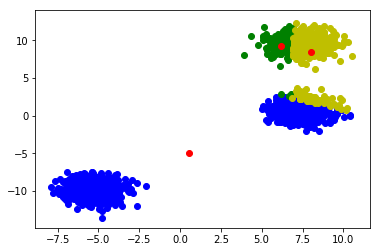

In [22]:
draw_clusters(assigned, new_centroids)

And now repeat the following iteration as often as you like... You will see how the centroids move and the algorithm  slowly finds the correct clustering. Eventually, when there is no reassignment of points any more, the algorithm stops.

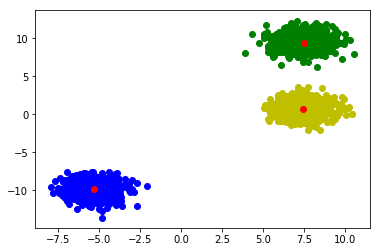

In [26]:
assigned, new_centroids = iteration(rdd, new_centroids)
draw_clusters(assigned, new_centroids)